In [1]:
%matplotlib inline
import torch  as t
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.ndimage
import math
import os
from torch.autograd import Variable as V
from numpy.linalg import inv
import cv2
import random

def affine_transform(input,mat):
    coor=coordinate_one()
    xyprime=t.tensordot(coor,t.t(mat),dims=1)
    return bilinear(input,xyprime)

def coordinate():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    return V(t.tensor(coor),True)

def coordinate_one():
    coor=np.asarray(np.meshgrid(np.arange(xsize), np.arange(ysize)))
    coor=np.rollaxis(coor,0,3)
    coor=np.rollaxis(coor,0,2)
    onesMatrix = np.ones((xsize,ysize,1))
    coorMatrix = np.concatenate((coor, onesMatrix), axis=2)
    return V(t.tensor(coorMatrix),True)

def nearest_neighbor(img,xyprime):
    xp=t.round(xyprime[:,:,0]).long()
    yp=t.round(xyprime[:,:,1]).long()
    xp=t.where(xp>xsize-1,t.tensor(xsize-1),xp)
    yp=t.where(yp>ysize-1,t.tensor(ysize-1),yp)
    return img[xp,yp]
    
def bilinear(img,xyprime):
    xp=xyprime[:,:,0]
    yp=xyprime[:,:,1]
    LUX=t.floor(xp).int()
    LUY=t.floor(yp).int()
    LUX=t.where(LUX>xsize-2,t.tensor(xsize-2),LUX.long())
    LUX=t.where(LUX<1,t.tensor(1),LUX)
    LUY=t.where(LUY>ysize-2,t.tensor(ysize-2),LUY.long())
    LUY=t.where(LUY<1,t.tensor(1),LUY)
    [a,b]=[yp-LUY.double(),xp-LUX.double()]
    [k00,k01,k10,k11]=[img[LUX,LUY],img[LUX,LUY+1],img[LUX+1,LUY],img[LUX+1,LUY+1]]
    return (1-b)*(a*k01+(1-a)*k00)+b*(a*k11+(1-a)*k10)   

def randxy(img,rate):
#     zeros=t.zeros(img.shape)
#     xsize,ysize=img.shape
#     i=0
    rst=t.empty(img.shape).uniform_(0, 1)
    return t.where(rst>t.tensor(rate),t.tensor(0),t.tensor(1))
#     while i<rate*xsize*ysize:
#         randx=random.randint(0,xsize-1)
#         randy=random.randint(0,ysize-1)
#         if zeros[randx][randy]==0:
#             i+=1
#             zeros[randx][randy]=1
#     return zeros
    
def imshow(img, mov, ref):
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("moving")
    
    plt.subplot(1,3,2)
    plt.imshow(mov)
    plt.title("after transformation")
    
    plt.subplot(1,3,3)
    plt.imshow(ref)
    plt.title("template")
    plt.show()



# Hand Rotation

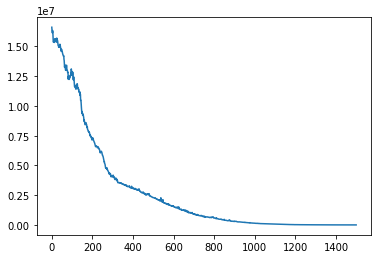

In [5]:
angle=10*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('hand.jpg')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.01
step=1e-9
iter=1500
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

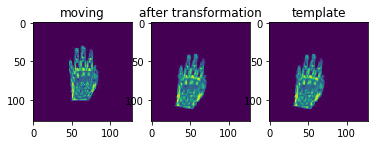

1283.9882970717365

In [7]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

# Hand Scale

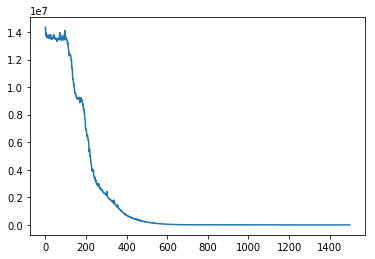

In [4]:
transformMatrix = V(t.Tensor([[0.9, -0.0, -0.0],[0.0, 0.9, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('hand.jpg')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.01
step=1e-9
iter=800
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

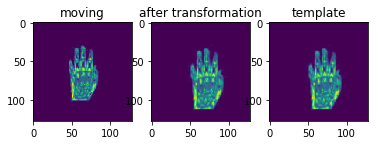

0.1254143143999341

In [5]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

# Hand Translation

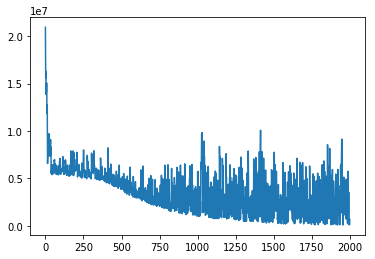

In [30]:
transformMatrix = V(t.Tensor([[1.0, -0.0, 15.0],[0.0, 1.0, 15.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('hand.jpg')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.01
step=1e-8
iter=2000
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=1e3*step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

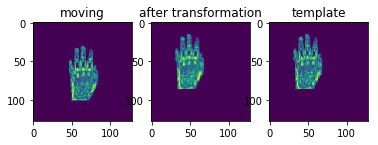

645534.7844260521

In [31]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

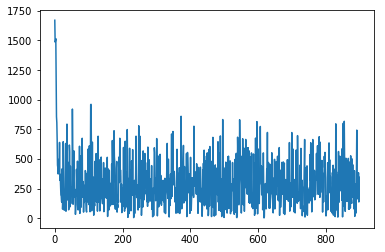

In [18]:
angle=5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed1.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.1
step=1e-4
iter=900
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

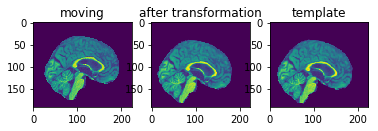

344.2694696918488

In [19]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

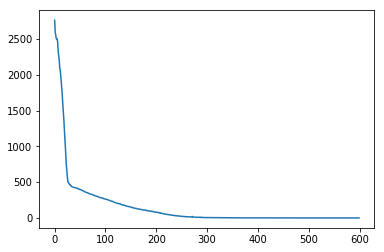

In [62]:
# angle=0*math.pi/180.0
# angle_sin = math.sin(angle)
# angle_cos = math.cos(angle)
# transformMatrix = V(t.Tensor([[angle_cos, -angle_sin, -0.0],[angle_sin, angle_cos, -0.0],[0.0, 0.0, 1.0]]).double(),True)
transformMatrix = V(t.Tensor([[1.0, -0.0, 10.0],[0.0, 1.0, 10.0],[0.0, 0.0, 1.0]]).double(),True)
# transformMatrix = V(t.Tensor([[1.1, -0.0, 0.0],[0.0, 1.1, 0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('MRI_2D/fixed2.png')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.01
step=1e-5
iter=600
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
        mat[:2,:2]-=step*mat.grad[:2,:2]
        mat[:2,2]-=step*mat.grad[:2,2]*1e4
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

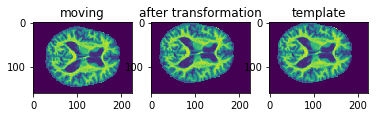

3.7903588287307655e-05

In [63]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

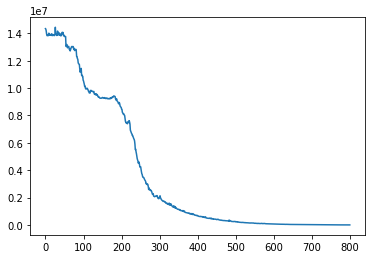

In [13]:
transformMatrix = V(t.Tensor([[0.9, -0.0, -0.0],[0.0, 0.9, -0.0],[0.0, 0.0, 1.0]]).double(),True)
mov=plt.imread('hand.jpg')
xsize,ysize=mov.shape
mov=V(t.tensor(mov).double(),True)
template=affine_transform(mov,transformMatrix)
rate=0.01
step=1e-9
iter=800
mat=V(t.tensor([[1.0,0.0,0.0],[0.0,1.0,0],[0.0,0.0,1.0]]).double(),True)
losses=[]
n=0.9
grad=t.zeros(mat.shape).double()
for i in range(iter):    
    tmplt=affine_transform(mov,mat)
    err=template-tmplt
    loss=t.sum(err[randxy(mov,rate)==1]**2)   
    loss.backward(retain_graph=True)
    losses.append(np.sum((tmplt.detach().numpy()-template.detach().numpy())**2))
    with t.no_grad():
#         mat[:2,:2]-=step*mat.grad[:2,:2]
#         mat[:2,2]-=step*mat.grad[:2,2]
        mat-=step*(mat.grad*(1-n)+n*grad)
        grad=mat.grad
        mat.grad.zero_()
plt.plot(np.arange(iter), losses)

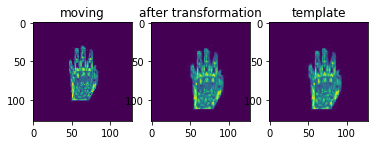

4756.7087991659155

In [14]:
imshow(mov.detach().numpy(),tmplt.detach().numpy(),template.detach().numpy())
losses[-1]

In [4]:
print("mov max"+str(t.max(mov)))
print("mov min"+str(t.min(mov)))
print("tmplt max"+str(t.max(tmplt)))
print("tmplt min"+str(t.min(tmplt)))
print("template max"+str(t.max(template)))
print("template min"+str(t.min(template)))

mov maxtensor(190., dtype=torch.float64, grad_fn=<MaxBackward1>)
mov mintensor(0., dtype=torch.float64, grad_fn=<MinBackward1>)
tmplt maxtensor(176.0040, dtype=torch.float64, grad_fn=<MaxBackward1>)
tmplt mintensor(0., dtype=torch.float64, grad_fn=<MinBackward1>)
template maxtensor(176.0600, dtype=torch.float64, grad_fn=<MaxBackward1>)
template mintensor(0., dtype=torch.float64, grad_fn=<MinBackward1>)
